## Import

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import seaborn as sns
from PIL import Image
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models

## Device

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Dataset

In [3]:
DATASET_PATH = "data/sign_mnist_train.csv"

### Helper function for saving images

In [4]:
import os

def save_fig(fig, fig_name, fig_dir, tight_layout=True, padding=False, transparent=True, fig_extension="png", resolution=300):
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    path = os.path.join(fig_dir, fig_name + "." + fig_extension)

    if tight_layout:
        plt.tight_layout()
    
    if not padding:
        fig.savefig(path, format=fig_extension, dpi=resolution, bbox_inches="tight", pad_inches=0, transparent=transparent)
    else:
        fig.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)
    print(f"Save {fig_name}.{fig_extension} in {fig_dir}")

## Define custom dataset, transforms, and dataloaders

### Custom dataset

In [5]:
class SignLanguageMNIST(Dataset):

    def __init__(self, csv_file, phase="train", val_split=0.25, shuffle=True, transform=None, label_transform=None):
        phases = ["train", "val", "test"]
        assert phase in phases, f"Choose phase from {phases}"

        self.data = pd.read_csv(csv_file).to_numpy(np.uint8)

        train_indices, val_indices = self._train_val_split(self.data, val_split=val_split, shuffle=shuffle)
        if phase == "train":
            self.data = self.data[train_indices]
        elif phase == "val":
            self.data = self.data[val_indices]
        
        self.images = self.data[:, 1:].reshape(-1, 28, 28, 1)
        self.labels = self.data[:, 0]

        self.transform = transform
        self.label_transform = label_transform


    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        label = torch.as_tensor(label, dtype=torch.long)

        return image, label


    def __len__(self):
        return len(self.labels)


    def _train_val_split(self, data, val_split=0.25, seed=42, shuffle=True):
        indices = np.arange(len(data))
        if shuffle:
            np.random.seed(seed)
            np.random.shuffle(indices)
        train_indices = indices[: int((1 - val_split) * len(indices))]
        val_indices = indices[int((1 - val_split) * len(indices)) :]

        return train_indices, val_indices


### Custom transforms

In [6]:
data_transforms = {
    "train": transforms.Compose([
        transforms.ToPILImage(),
        
        transforms.Resize(224),

        # data augmentation
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
        # transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),
    ]),
    
    "val": transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
}

### Split training and validation set

In [7]:
sign_language_datasets = {x: SignLanguageMNIST(DATASET_PATH, phase=x, transform=data_transforms[x]) for x in ["train", "val"]}
dataset_sizes = {x: len(sign_language_datasets[x]) for x in ["train", "val"]}

dataset_sizes

{'train': 20591, 'val': 6864}

### Dataloaders

In [8]:
BATCH_SIZE = 32
NUM_WORKERS = 8

In [9]:
dataloaders = {x: torch.utils.data.DataLoader(sign_language_datasets[x], batch_size=BATCH_SIZE, 
                                              shuffle=True, num_workers=NUM_WORKERS) 
               for x in ['train', 'val']}

## Models

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=25):
        super(SimpleCNN, self).__init__()
        self.Conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5), # 220, 220
            nn.MaxPool2d(2), # 110, 110
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.Conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5), # 106, 106
            nn.MaxPool2d(2),  # 53,53
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.Conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 51, 51
            nn.MaxPool2d(2), # 25, 25
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.Conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3), # 23, 23
            nn.MaxPool2d(2), # 11, 11
            nn.ReLU(),            
            nn.BatchNorm2d(256)
        )
        self.Conv5 = nn.Sequential(
            nn.Conv2d(256, 512, 3), # 9, 9
            nn.MaxPool2d(2), # 4, 4
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        
        self.Linear1 = nn.Linear(512 * 4 * 4, 256)
        self.dropout=nn.Dropout(0.1)
        self.Linear3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x = self.dropout(x)
        x = self.Conv5(x)
        x = x.flatten(start_dim=1)
        x = self.Linear1(x)
        x = self.dropout(x)
        x = self.Linear3(x)
        return x

In [12]:
def get_alexnet(num_classes=25):
    model = models.alexnet(num_classes=num_classes)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
    return model

In [13]:
def get_resnet(num_classes=25):
    model = models.resnet18(num_classes=num_classes)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    return model

In [14]:
def get_squeezenet(num_classes=25):
    model = models.squeezenet1_0(num_classes=num_classes)
    model.features[0] = nn.Conv2d(1, 96, kernel_size=7, stride=2)
    return model

In [15]:
def get_vgg(num_classes=25):
    model = models.vgg11_bn(num_classes=num_classes)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    return model

In [17]:
torch.manual_seed(0) # ensure reproducibility

exp_models = {
    "simple_cnn": SimpleCNN(),
    "alexnet": get_alexnet(),
    "resnet": get_resnet(),
    "vgg11_bn": get_vgg(),
}
exp_models = {model_name: model.to(device) for model_name, model in exp_models.items()}

## Train

In [18]:
train_val_loss = {x: list() for x in ["train", "val"]}
train_val_acc = {x: list() for x in ["train", "val"]}

In [19]:
writer = SummaryWriter("runs/sign_languange")

def train(exp_models, criterion, writer, model_train_val_loss_dict, model_train_val_acc_dict, num_epochs=25):
    for model_name, model in exp_models.items():

        print(f"Train {model_name}")

        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        train_val_loss = model_train_val_loss_dict.get(model_name)
        train_val_acc = model_train_val_acc_dict.get(model_name)

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        train_val_loss_dict = dict()
        train_val_acc_dict = dict()

        for epoch in range(1, num_epochs+1):
            print(f"{model_name}: Epoch {epoch}")
            print("-" * 20)

            for phase in ["train", "val"]:

                if phase == "train":
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for images, labels in dataloaders[phase]:
                    # Move to GPU
                    images = images.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # forward
                    # track history if only in train phase
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(images)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only in trianing phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * images.shape[0]
                    running_corrects += torch.sum(preds == labels.data).item()

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                train_val_loss[phase].append(epoch_loss)
                writer.add_scalar(f"Loss/{model_name}/{phase}", epoch_loss, epoch)

                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                train_val_acc[phase].append(epoch_acc)
                writer.add_scalar(f"Accuracy/{model_name}/{phase}", epoch_acc, epoch)
                
                train_val_loss_dict.update({phase: epoch_loss})
                train_val_acc_dict.update({phase: epoch_acc})

                print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

                # deep copy model weights if new best model occurs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("New best model!")

            # writer.add_scalars("Loss: Train vs. Val", train_val_loss_dict, epoch)
            # writer.add_scalars("Accuracy: Train vs. Val", train_val_acc_dict, epoch)
            print()

        # load best model weights
        model.load_state_dict(best_model_wts)

    return exp_models

Loss function:

In [20]:
criterion = nn.CrossEntropyLoss()

model_train_val_loss_dict = {model: {x: list() for x in ["train", "val"]} for model in exp_models.keys()}
model_train_val_acc_dict = {model: {x: list() for x in ["train", "val"]} for model in exp_models.keys()}

Kick off training:

In [21]:
trained_models = train(exp_models, criterion, writer, model_train_val_loss_dict, model_train_val_acc_dict, num_epochs=25)

Train simple_cnn
simple_cnn: Epoch 1
--------------------
train Loss: 1.1060, Acc: 0.7926
val Loss: 2.8741, Acc: 0.7921
New best model!

simple_cnn: Epoch 2
--------------------
train Loss: 1.0528, Acc: 0.9165
val Loss: 0.2817, Acc: 0.9783
New best model!

simple_cnn: Epoch 3
--------------------
train Loss: 0.3452, Acc: 0.9695
val Loss: 0.0175, Acc: 0.9964
New best model!

simple_cnn: Epoch 4
--------------------
train Loss: 0.1343, Acc: 0.9865
val Loss: 0.0143, Acc: 0.9984
New best model!

simple_cnn: Epoch 5
--------------------
train Loss: 0.0919, Acc: 0.9913
val Loss: 0.0015, Acc: 0.9996
New best model!

simple_cnn: Epoch 6
--------------------
train Loss: 0.0713, Acc: 0.9932
val Loss: 0.0126, Acc: 0.9980

simple_cnn: Epoch 7
--------------------
train Loss: 0.0572, Acc: 0.9942
val Loss: 0.0010, Acc: 0.9997
New best model!

simple_cnn: Epoch 8
--------------------
train Loss: 0.0297, Acc: 0.9970
val Loss: 0.0000, Acc: 1.0000
New best model!

simple_cnn: Epoch 9
-------------------

## Test

In [22]:
TEST_SET = "data/sign_mnist_test.csv"
test_set = SignLanguageMNIST(TEST_SET, phase="test", transform=data_transforms["val"])
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS) 

In [27]:
# from tqdm.notebook import tqdm

test_acc_dict = dict()


for model_name, model in trained_models.items():
    correct = 0
    model.eval()
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, preds = _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    test_acc = round(correct / len(test_set), 4)
    test_acc_dict.update({model_name: test_acc})
    
    print(f"{model_name}: Accuracy on test set is {test_acc}")

simple_cnn: Accuracy on test set is 0.9833
alexnet: Accuracy on test set is 0.9933
resnet: Accuracy on test set is 0.9997
vgg11_bn: Accuracy on test set is 0.99


## Number of model parameters

In [28]:
def get_param_num(model):
    return sum(p.numel() for p in model.parameters())

In [32]:
model_params_num_dict = dict()

for model_name, model in exp_models.items():
    model_params_num_dict.update({model_name: get_param_num(model)})

In [33]:
model_params_num_dict

{'simple_cnn': 3707097,
 'alexnet': 57090777,
 'resnet': 11183065,
 'vgg11_bn': 128873113}

## Plotting

In [36]:
plt.style.use('ggplot')

### Loss

In [ ]:
model_train_val_loss_dict

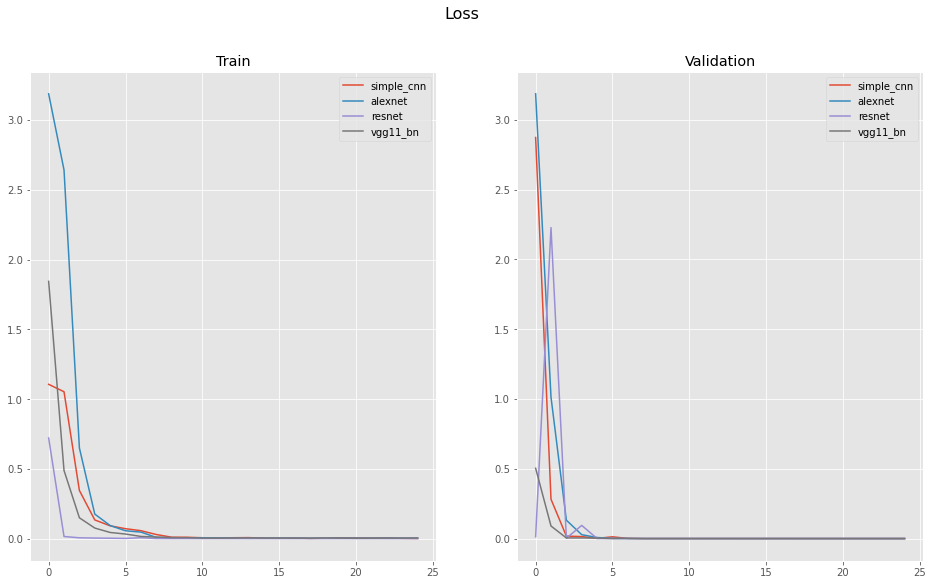

In [49]:
fig = plt.figure(figsize=(16, 9))
fig.suptitle('Loss', fontsize=16)

ax_train_loss = fig.add_subplot(1, 2, 1)
ax_train_loss.set_title("Train")
for model_name, train_val_loss in model_train_val_loss_dict.items():
    ax_train_loss.plot(train_val_loss["train"], label=model_name)
ax_train_loss.legend()

ax_val_loss = fig.add_subplot(1, 2, 2)
ax_val_loss.set_title("Validation")
for model_name, train_val_loss in model_train_val_loss_dict.items():
    ax_val_loss.plot(train_val_loss["val"], label=model_name)
ax_val_loss.legend()

In [47]:
save_fig(fig, "train_val_loss", ".", resolution=100)

Save train_val_loss.png in .


<Figure size 432x288 with 0 Axes>

### Accuracymodel_train_val_acc_dict

In [ ]:
model_train_val_acc_dict

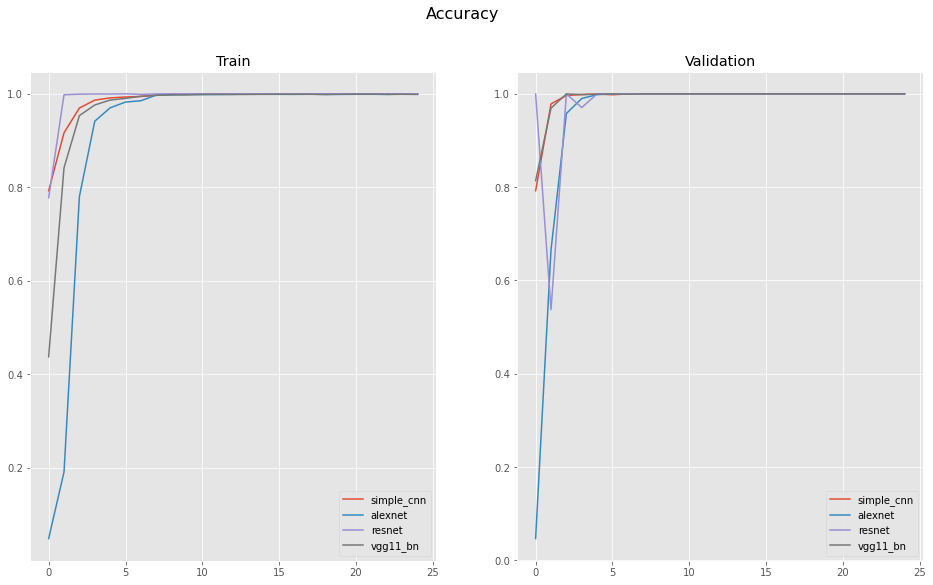

In [60]:
fig = plt.figure(figsize=(16, 9))
fig.suptitle('Accuracy', fontsize=16)

ax_train_acc = fig.add_subplot(1, 2, 1)
ax_train_acc.set_title("Train")
for model_name, train_val_acc in model_train_val_acc_dict.items():
    ax_train_acc.plot(train_val_acc["train"], label=model_name)
ax_train_acc.legend()

ax_val_acc = fig.add_subplot(1, 2, 2)
ax_val_acc.set_title("Validation")
for model_name, train_val_acc in model_train_val_acc_dict.items():
    ax_val_acc.plot(train_val_acc["val"], label=model_name)
ax_val_acc.legend()

In [61]:
save_fig(fig, "train_val_acc", ".", resolution=100)

Save train_val_acc.png in .


<Figure size 432x288 with 0 Axes>

## Dataframe

In [62]:
test_acc_dict

{'simple_cnn': 0.9833, 'alexnet': 0.9933, 'resnet': 0.9997, 'vgg11_bn': 0.99}

In [63]:
model_params_num_dict

{'simple_cnn': 3707097,
 'alexnet': 57090777,
 'resnet': 11183065,
 'vgg11_bn': 128873113}

In [64]:
import pandas as pd

test_acc_df = pd.DataFrame(test_acc_dict.items(), columns=["Model", "Test Acc"])
test_acc_df

,Model,Test Acc
0,simple_cnn,0.9833
1,alexnet,0.9933
2,resnet,0.9997
3,vgg11_bn,0.9900


In [65]:
model_params_num_df = pd.DataFrame(model_params_num_dict.items(), columns=["Model", "#Params"])
model_params_num_df

,Model,#Params
0,simple_cnn,3707097
1,alexnet,57090777
2,resnet,11183065
3,vgg11_bn,128873113


In [67]:
summary_df = pd.merge(test_acc_df, model_params_num_df, on="Model")
summary_df

,Model,Test Acc,#Params
0,simple_cnn,0.9833,3707097
1,alexnet,0.9933,57090777
2,resnet,0.9997,11183065
3,vgg11_bn,0.9900,128873113
